# Linear Blending Problems

This notebook introduces material blending problems and outlines a multi-step procedure for developing and solving models using Pyomo.

In [1]:
# install Pyomo and solvers for Google Colab
import sys
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper
    colab_helper.install_idaes()
    colab_helper.install_ipopt()

# Set default font sizes for plots
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 3.0

# Alternately, you can set these individually
#plt.rcParams['axes.labelsize'] = 18
#plt.rcParams['axes.titlesize'] = 18
#plt.rcParams['xtick.labelsize'] = 18
#plt.rcParams['ytick.labelsize'] = 18
#plt.rcParams['legend.fontsize'] = 18




## Learning Goals

1. Linear Blending problems

    * Frequently encountered in material blending 
    
    * Models generally consist of linear mixing rules and mass/material balances
    
    * Decision variables are indexed by a set of raw materials


2. Further practice with key elements of modeling for optimization

    * `pyo.ConcreteModel()` to create a new instancce of an optimization model
    
    * `pyo.Set()` to create an index used to index decision variables
    
    * `pyo.Var()` to create an optimization **decision variable**
    
    * `model.Comstraint()` to decorate (tag) the output of a function as an optimization constraint
    
    * `model.Objective()` to decorate (tag) the output of a function as an optimization objective


3. Modeling and solving linear blending problems in Pyomo

    * Step 1. Coding problem data. Nested dictionaries or Pandas dataframes.
    
    * Step 2. Create index set. Use .keys() with nested dictionaries, or .index with Pandas dataframes.
    
    * Step 3. Create a dictionary of decision variables. Add any pertinent qualifiers or constraints for individual variables such as lower and upper bounds, non-negativity, variable names.
    
    * Step 4. Create an expression defining the problem objective.
    
    * Step 5. Create a one or more lists of problem constraints.
    
    * Step 6. Create the problem object from the objectives and constraints.
    
    * Step 7. Solve and display the solution.

## Problem Statement (Jenchura, 2017)

A brewery receives an order for 100 gallons that is at least 4\% ABV (alchohol by volume) beer. The brewery has on hand beer A that is 4.5% ABV and costs \$0.32 per gallon to make, and beer B that is 3.7% ABV and costs \$0.25 per gallon. Water (W) can also be used as a blending agent at a cost of \$0.05 per gallon. Find the minimum cost blend of A, B, and W that meets the customer requirements.

## Analysis

Before going futher, carefully read the problem description with the following questions in mind.

* What are the decision variables?
* What is the objective?
* What are the constraints?


### Decision variables

The decision variables for this problem are the amounts of blending stocks "A", "B", and "W" to included in the final batch.  We can define a set of blending stocks $S$, and non-negative decision variables $x_s$ that are indexed by the components in $S$ that denote the amount of $s$ included in the final batch.

### Objective

If we designate the price of blending stock $s \in S$ as $P_s$, the cost is 

$$
\begin{align}
\text{cost} & = \sum_{s\in C} x_s P_s
\end{align}
$$

The objective is to minimize cost.

### Constraints

#### Order Volume

Let $V = 100$ represent the desired volume of product and assume ideal mixing. Then

$$\begin{align}
V &  = \sum_{s\in S} x_s
\end{align}$$

#### Alcohol by Volume

Let $C_s$ denote the volume fraction of alcohol in blending stock $s$. Assuming ideal mixing, the total volume of of alchohol in the final product be

$$C_{total} = \sum_{s\in S} x_s C_s$$

If $\bar{C}$ denotes the required average concentration, then 

$$\frac{C_{total}}{V} \geq \bar{C} \qquad \implies \qquad \frac{\sum_{s\in S} x_s C_s}{\sum_{s\in S} x_s} \geq \bar{C}$$

Which is not linear in the decision variables. If at all possible, linear constraints are much preferred because (1) they enable the use of LP solvers, and (2) then tend to avoid problems that can arise with division by zero and other issues.

$$\sum_{s\in S} (C_s - \bar{C}) x_s \geq 0$$

There are other ways to write composition constraints, but this one is preferred because it isolates the product quality parameter, $\bar{C}$, in a single constraint.  This constraint has "one job to do".

## Solving optimization problems with Pyomo

### Step 1. Coding Problem Data as a Pandas DataFrame

The first step is to represent the problem data in a generic manner that could be extended to include additional blending components.  Here we use a Pandas dataframe of raw materials, each row representing a unique blending agent, and columns containing attributes of the blending components. This is consistent with ["Tidy Data" principles](../../python/A.05-Tidy-Data-and-Pandas.ipynb).

In [2]:
import pandas as pd

data = pd.DataFrame([
    ['A', 0.045, 0.32],
    ['B', 0.037, 0.25],
    ['W', 0.000, 0.05]], 
    columns = ['blending stock', 'Concentration', 'Price']
)

data.set_index('blending stock', inplace=True)
display(data)

,Concentration,Price
blending stock,,
A,0.045,0.32
B,0.037,0.25
W,0.000,0.05


### Step 2. Creating a model instance

In [3]:
import numpy as np
import pyomo.environ as pyo

bm = pyo.ConcreteModel('Blending Model')

### Step 3. Identifying index sets

The objectives and constraints encountered in optimization problems often include sums over a set of objects. In the case, we will need to create sums over the set of blending stocks. We will use these index sets to create decision variables and to express the sums that appear in the objective and constraints

In [4]:
data.index

Index(['A', 'B', 'W'], dtype='object', name='blending stock')

In [5]:
bm.S = pyo.Set(initialize=data.index)

for s in bm.S:
    print(s)

A
B
W


### Step 4. Create decision variables

Most real-world applications of optimization technologies involve many decision variables and constraints. It would be impractical to create unique identifiers for literally thousands of variables. For this reason, the `pyo.Var()` and other objects can create indexed sets of variables and constraints. Here is how it is done for the blending problem.

In [6]:
bm.x = pyo.Var(bm.S, domain=pyo.NonNegativeReals)

### Step 4. Objective Function

If we let subscript $d$ denote a blending d from the set of blending components $C$, and denote the volume of $c$ used in the blend as $x_c$, the cost of the blend is

$$
\begin{align}
\text{cost} & = \sum_{s\in S} x_s P_s
\end{align}
$$

where $P_s$ is the price per unit volume of $s$. Using the Python data dictionary defined above, the price $P_s$ is given by `data[s, 'Price']`

In [7]:
@bm.Objective(sense=pyo.minimize)
def cost(bm):
    return sum(bm.x[s] * data.loc[s, "Price"] for s in bm.S)

bm.cost.pprint()

cost : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 0.32*x[A] + 0.25*x[B] + 0.05*x[W]


### Step 5. Constraints

#### Volume Constraint

The customer requirement is produce a total volume $V$. Assuming ideal solutions, the constraint is given by

$$\begin{align}
V &  = \sum_{s\in s} x_s
\end{align}$$

where $x_s$ denotes the volume of blending stock $s$ used in the blend.

In [8]:
V = 100

@bm.Constraint()
def volume(bm):
    return sum(bm.x[s] for s in bm.S) == V

bm.volume.pprint()

volume : Size=1, Index=None, Active=True
    Key  : Lower : Body               : Upper : Active
    None : 100.0 : x[A] + x[B] + x[W] : 100.0 :   True


#### Composition Constraint

In [9]:
C_lb = 0.04

@bm.Constraint()
def composition(bm):
    return sum(bm.x[s]*(data.loc[s, "Concentration"] - C_lb) for s in bm.S) >= 0

bm.composition.pprint()

composition : Size=1, Index=None, Active=True
    Key  : Lower : Body                                                                : Upper : Active
    None :   0.0 : 0.0049999999999999975*x[A] - 0.0030000000000000027*x[B] - 0.04*x[W] :  +Inf :   True


### Step 6. Solve

In [10]:
bm.pprint()

1 Set Declarations
    S : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'W'}

1 Var Declarations
    x : Size=3, Index=S
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          A :     0 :  None :  None : False :  True : NonNegativeReals
          B :     0 :  None :  None : False :  True : NonNegativeReals
          W :     0 :  None :  None : False :  True : NonNegativeReals

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 0.32*x[A] + 0.25*x[B] + 0.05*x[W]

2 Constraint Declarations
    composition : Size=1, Index=None, Active=True
        Key  : Lower : Body                                                                : Upper : Active
        None :   0.0 : 0.0049999999999999975*x[A] - 0.0030000000000000027*x[B] - 0.04*x[W] :  +Inf :   True
    volume : Size=1, Index=None, Activ

In [11]:
#solver = pyo.SolverFactory('glpk')
solver = pyo.SolverFactory('cbc')
solver.solve(bm, tee=True).write()

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Jun  7 2023 

command line - /Users/adowling/.idaes/bin/cbc -printingOptions all -import /var/folders/3w/vr4xmyqs451dg23xk88pqcg00000gq/T/tmpr9unbj4s.pyomo.lp -stat=1 -solve -solu /var/folders/3w/vr4xmyqs451dg23xk88pqcg00000gq/T/tmpr9unbj4s.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 2 (0) rows, 3 (0) columns and 6 (0) elements
Statistics for presolved model


Problem has 2 rows, 3 columns (3 with objective) and 6 elements
Column breakdown:
3 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
1 of type E other, 1 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 

### Step 7. Display solution

Following solution, the values of any Pyomo variable, expression, objective, or constraint can be accessed using the associated `value` property.

In [12]:
bm.pprint()

1 Set Declarations
    S : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'W'}

1 Var Declarations
    x : Size=3, Index=S
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          A :     0 :  37.5 :  None : False : False : NonNegativeReals
          B :     0 :  62.5 :  None : False : False : NonNegativeReals
          W :     0 :   0.0 :  None : False : False : NonNegativeReals

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 0.32*x[A] + 0.25*x[B] + 0.05*x[W]

2 Constraint Declarations
    composition : Size=1, Index=None, Active=True
        Key  : Lower : Body                                                                : Upper : Active
        None :   0.0 : 0.0049999999999999975*x[A] - 0.0030000000000000027*x[B] - 0.04*x[W] :  +Inf :   True
    volume : Size=1, Index=None, Activ

In [13]:
print(bm.cost())

27.625


In [14]:
print(f"Minimum cost to produce {V} gallons at greater than ABV={C_lb}: ${bm.cost():5.2f}")

Minimum cost to produce 100 gallons at greater than ABV=0.04: $27.62


In [15]:
for s in bm.S:
    print(f"{s}: {bm.x[s]():6.2f} gallons")

A:  37.50 gallons
B:  62.50 gallons
W:   0.00 gallons


## Parametric Studies

An important use of optimization models is to investigate how operations depend on critical parameters. For example, for this blending problem we may be interested in questions like:

* How does the operating cost change with product alcohol content?
* What is the cost of producing one more gallon of product?
* What if the supply of a raw material is constrained?
* What if we produce two products rather than one?
* How much would be pay for raw materials with different specifications

### Consolidating the model into a single function to create and solve for optimal blend

To enable parametric studies, our first step is to consolidate the model into a function that accepts problem data and reports an optimal solution.

In [ ]:
def blend_beer(data, V=100, C_lb=0.04, opt_solver='cbc'):
    ''' Create and solve blending optimization model for beer production
    
    Arguments:
        data: pandas DataFrame with columns ['blending stock', 'Concentration', 'Price']
        V: float, total volume of beer to produce
        C_lb: float, lower bound on alcohol by volume (ABV) of beer
        opt_solver: str, name of optimization solver to use

    Returns:
        bm: Pyomo model object (solved)

    '''
    
    # create model
    bm = pyo.ConcreteModel('Blending Model')

    # create index set for decision variables
    bm.S = pyo.Set(initialize=data.index)

    # create decision variables
    bm.x = pyo.Var(bm.S, domain=pyo.NonNegativeReals)

    # specify objective
    @bm.Objective(sense=pyo.minimize)
    def cost(bm):
        return sum(bm.x[s] * data.loc[s, "Price"] for s in bm.S)

    # volume constraint
    @bm.Constraint()
    def volume(bm):
        return sum(bm.x[s] for s in bm.S) == V

    # composition constraint
    @bm.Constraint()
    def composition(bm):
        return sum(bm.x[s]*(data.loc[s, "Concentration"] - C_lb) for s in bm.S) >= 0

    # solve model
    solver = pyo.SolverFactory(opt_solver)
    solver.solve(bm)
    
    # return model for post-processing and display
    return bm

### How to use the optimization model

,Concentration,Price
blending stock,,
A,0.045,0.32
B,0.037,0.25
W,0.000,0.05


Minimum cost to produce 100 gallons at ABV=0.04 = $27.62


,amount
A,37.5
B,62.5
W,0.0


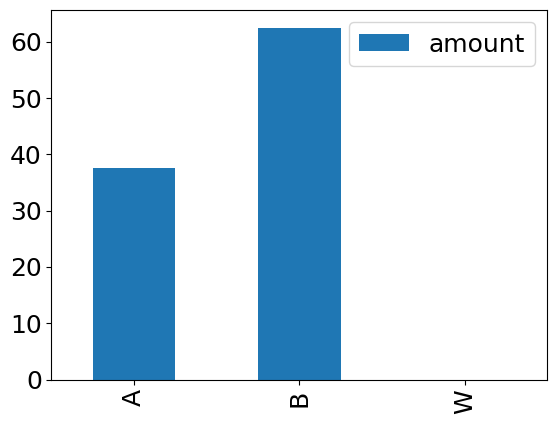

In [19]:
# specify blending stock data
data = pd.DataFrame([
    ['A', 0.045, 0.32],
    ['B', 0.037, 0.25], 
    # ['C', .042, .28],
    ['W', 0.000, 0.05]], 
    columns = ['blending stock', 'Concentration', 'Price']
)
data.set_index('blending stock', inplace=True)
display(data)

# set product requirements
volume = 100
abv = 0.04

# compute optimal solution using optimization model
bm = blend_beer(data, volume, abv)

# extract data from the model
optimal_blend = pd.DataFrame()
optimal_blend.index = [s for s in bm.S]
optimal_blend["amount"] = [bm.x[s]() for s in bm.S]
min_cost = bm.cost()

# display solutoin
print(f"Minimum cost to produce {volume} gallons at ABV={abv} = ${min_cost:5.2f}")
display(optimal_blend)
optimal_blend.plot(y="amount", kind="bar", fontsize=18)
plt.show()

## Parametric Study

The following cell uses the optimal blending model to compute the minimum cost and blending stocks to produce 

                Concentration  Price
blending stock                      
A                       0.045   0.32
B                       0.037   0.25
W                       0.000   0.05


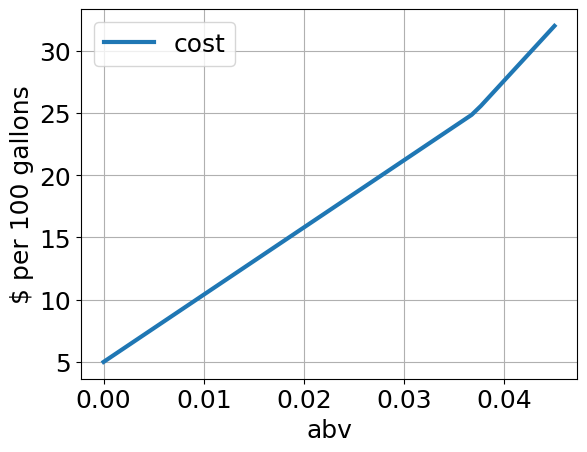

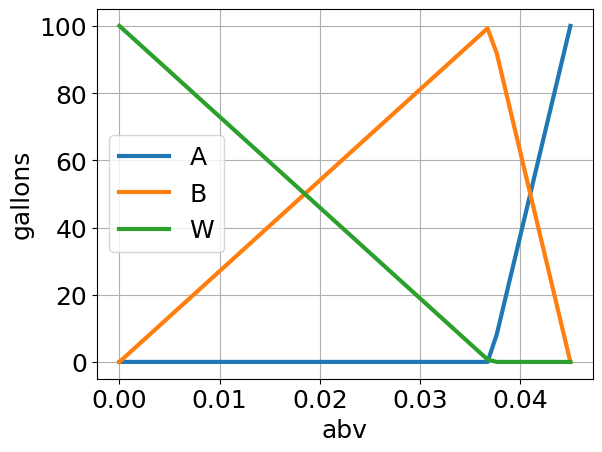

In [18]:
print(data)
volume = 100

# gather results for a range of abv values
abv = np.linspace(0, 0.045)

results = pd.DataFrame(columns=["abv", "cost", "A", "B", "W"])
for row, a in enumerate(abv):
    bm = blend_beer(data, volume, a)
    results.loc[row] = [a, bm.cost(), bm.x["A"](), bm.x["B"](), bm.x["W"]()]

results.plot(x="abv", y="cost", ylabel="$ per 100 gallons", grid=True)
results.plot(x="abv", y=["A", "B", "W"], ylabel="gallons", grid=True)

plt.show()

## Study Exercises

### Exercise 1

An additional raw blending stock "C" becomes available with an abv of 4.2% at a cost of 28 cents per gallon. How does that change the optimal blend for a product volume of 100 gallons and an abv of 4.0%?

### Exercise 2

Having decided to use "C" for the blended product, you later learn only 50 gallons of "C" are available. Modify the solution procedure to allow for limits on the amount of raw maaterial, and investigate the implications for the optimal blend of having only 50 gallons of "C" available, and assuming the amounts of the other components "A", "B", and "W" remain unlimited.

### Exercise 3

An opportunity has developed to sell a second product with an abv of 3.8\%. The first product is now labeled "X" with abv 4.0% and sells for \$1.25 per gallon, and the second product is designated "Y" and sells for \$1.10 per gallon. You've also learned that all of your raw materials are limited to 50 gallons. What should your production plan be to maximize profits?

